<a href="https://colab.research.google.com/github/McWilliamsCenter/galsim_hub/blob/master/notebooks/GalsimHubDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to GalSim Hub

Authors: [@EiffL](https://github.com/EiffL)

This notebook contains a short introduction to using GalSim-Hub for sampling
randomly generated galaxy light profiles, and drawing them using GalSim.


## Setting up the environment

Besides GalSim, GalSim-Hub requires TensorFlow (version 1.15, for stability reasons), and TensorFlow Hub. In a Colab environment, TensorFlow is already installed, so we only need to install GalSim, using some conda magic.

In [16]:
# Activating TensorFlow v1.15 environment on Colab
%tensorflow_version 1.x

In [ ]:
# Installing and updating conda for Python 3.6
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
!conda install --channel defaults conda python=3.6 --yes
!conda update --channel defaults --all --yes

# Installing GalSim
!conda install -y -q -c conda-forge galsim=2.2.4=py36hbfbe4e9_0

# Adding conda packages to Python path 
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

And finally, installing GalSim Hub itself:

In [ ]:
!pip install --no-deps git+https://github.com/McWilliamsCenter/galsim_hub.git

## Loading and Using generative models from Python

The first step is to load a generative model. This is done by creating an instance of the `galsim_hub.GenerativeGalaxyModel` class, either by providing a local path to a model directory, or much more conveniently, by
using the `hub:xxxxxx` syntax, where `xxxxxx` is the name of a published model, hosted on the GalSim Hub repository, see [here](https://github.com/McWilliamsCenter/galsim_hub/tree/master/hub).

As an example, we will load the generative model presented in Lanusse et al. 2020:

In [17]:
import galsim
import galsim_hub

model = galsim_hub.GenerativeGalaxyModel('hub:Lanusse2020')

Behind the scene, the generative model has been downloaded from the repository,
and is now ready to use.

Models can be conditional, i.e. generating a light profile given some particular attributes as inputs. To introspect the model, and see what inputs are expected, you can use the `quantities` attribute: 

In [18]:
model.quantities

['mag_auto', 'zphot', 'flux_radius']

We see that this model generates light profiles, given a particular magnitude, redshift, and size.

Other interesting properties saved with the model (but knowledge of which is not necessary) are the native stamp size, and native pixel size at which the generative model is producing light profiles: 

In [21]:
# Pixel size, in arcsec
model.pixel_size

0.029999999329447746

In [22]:
# Stamp size
model.stamp_size

128

Now that the model is loaded, and that we know what inputs it expects, we can 
create a catalog listing some desired input quantities:

In [24]:
from astropy.table import Table
catalog = Table([[5., 10. ,20.], [24., 24., 24.], [0.5, 0.5, 0.5] ],
             names=['flux_radius', 'mag_auto', 'zphot'])

In this example, we want 3 galaxies, all at the same i-band magnitude of 24, and redshift 0.5, but with different and increasing size.


We can now sample actual GalSim light profiles with those properties from the model using the `sample()` method:

In [37]:
# Sample light profiles for these parameters
profiles = model.sample(catalog)

This returns a list of 3 profiles, represented by `galsim.InterpolatedImage` objects:

In [38]:
profiles[0]

galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-64, xmax=63, ymin=-64, ymax=63), array=
array([[9.87004169e-05, 7.12846158e-05, 3.69548115e-06, ...,
        5.51923767e-05, 5.84123791e-06, 7.80830931e-07],
       [2.82522033e-05, 2.02655588e-06, 3.95767020e-05, ...,
        9.52491774e-09, 1.31130128e-06, 3.44840089e-07],
       [1.30764034e-04, 1.19209221e-06, 1.71408261e-04, ...,
        2.86098202e-05, 1.27553130e-05, 1.07288304e-06],
       ...,
       [4.50377740e-07, 3.54935148e-09, 5.36995117e-07, ...,
        9.67625535e-10, 2.32073551e-04, 2.22918879e-05],
       [1.56162951e-05, 9.53673862e-07, 4.64915138e-06, ...,
        3.09209952e-07, 1.41858045e-05, 2.14576494e-06],
       [2.20534748e-05, 7.15253191e-06, 9.18443277e-08, ...,
        2.84755544e-08, 1.06095704e-05, 3.00490015e-08]]), wcs=galsim.PixelScale(0.029999999329447746)), galsim.Quintic(gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), galsim.Quinti

**These objects can now be manipulated inside GalSim as any other light profile.**

For instance, we can convolve these images with a PSF and add some observational noise:

Populating the interactive namespace from numpy and matplotlib


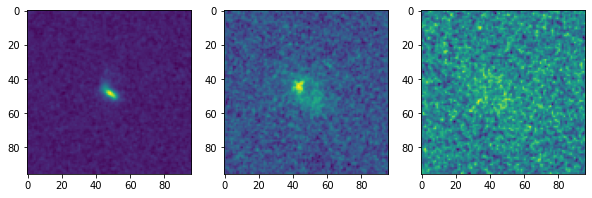

In [40]:
%pylab inline

PSF = galsim.Gaussian(fwhm=0.06)

figure(figsize=(10,5))

for i in range(3):

  # Convolving light profile with PSF
  gal = galsim.Convolve(profiles[i], PSF)

  # Drawing postage stamp of any desired size and pixel scale
  im = gal.drawImage(nx=96, ny=96, scale=0.03)

  # Adding some noise for realism
  im.addNoise(galsim.getCOSMOSNoise())

  # Drawing the image
  subplot(1,3,i+1)
  imshow(im.array)

And voila!

## Using generative models directly from Yaml

GalSim Hub also provides a driver for using generative models direclty from 
a GalSim Yaml script. In this section, we will illustrate how to write such a script and execute it from the command line.

Let's retrieve a script from the example folder of GalSim Hub:

In [45]:
!wget -q https://raw.githubusercontent.com/McWilliamsCenter/galsim_hub/master/examples/demo14.yaml
!cat demo14.yaml

modules:
    - galsim_hub

psf :
    type : Gaussian
    sigma : 0.06  # arcsec

# Define the galaxy profile
gal :
    type : GenerativeModelGalaxy
    flux_radius : { type : Random , min : 5, max : 10 }
    mag_auto : { type : Random , min : 24., max : 25. }

# The image field specifies some other information about the image to be drawn.
image :
    type : Tiled
    nx_tiles : 10
    ny_tiles : 10

    stamp_size : 64  # pixels

    pixel_scale : 0.03  # arcsec / pixel

    noise :
       type : COSMOS

output :
    dir : output_yaml
    file_name : demo14.fits

# Define the input files
input :
    generative_model :
        file_name : 'hub:cosmos_size_mag'


Note the following points that are directly related to generative models:
  - In the preamble of the file, we load the `galsim_hub` module
  - In the galaxy section, we use the `GenerativeModelGalaxy` type, and provide some input distributions for the input quantities used by the model
  - In the `input` section, we provide the path to the generative model, or as 
  in this case, only its hub tag, so that it can be automatically downloaded.

We direct the interested reader to the GalSim documentation for further details on how to compose such a Yaml file.

We can now execute that file from the command line:

In [ ]:
!python /galsim demo14.yaml

This should generate a fits file corresponding to the Yaml description. Unfortunately, couldn't manage to get it to work yet on this hybrid conda/google environment... Suggestions welcome :-)